# **Variance Risk Premium Harvesting**

The **Variance Risk Premium (VRP)** is the persistent gap between **implied volatility (IV)** – the market’s price for future variance – and **realized volatility (RV)** – the variance that actually occurs.
Across years of data, IV tends to exceed RV because option sellers demand compensation for tail risk, crash hedging flows, and balance-sheet usage.

## **Why not blindly harvesting it?**

Blindly shorting volatility to collect this premium, however, is a recipe for large, clustered drawdowns in stress regimes. Our goal in this notebook is not to sell vol all the time, but to **harvest VRP selectively**, with explicit regime detection, position sizing, and risk filters.

For that:

- We treat **VRP as the primary edge** and aim to be **short variance** mainly in regimes where historical evidence shows IV > future RV on average.  
- We use **simple regime signals** (e.g. IV percentile buckets) to decide *when* VRP harvesting is acceptable and how large the position should be.  
- We add **tail-risk filters** (e.g. extreme IV levels, inverted term structure, vol-of-vol shocks) to **deactivate or shrink** the strategy in environments where short vol historically blows up.

The objective is not to eliminate risk, but to **capture the structural VRP while avoiding the most dangerous states**, improving the **risk-adjusted** profile of short-volatility carry.

The notebook is structured as follows:

1. [Read daily SPX Options chain & intraday SPX Index](#read_data)
2. [The Variance Risk Premium (VRP) — Stylized Facts](#vrp)
3. [Implementation Choice – How We Harvest VRP]()
4. [Baseline Strategy Prototype]()
5. [Trading Filters – Regimes & Tail-Risk Filters ]()
6. [Risk Management Overlay]()
7. [Simple Regime-Based Position Sizing]()
8. [Robustness/Reality & Regime Checks]()
9. [Final Evaluation Window ("True OOS")]()
10. [Conclusion](#plot_iv)  

In [158]:
%load_ext autoreload
%autoreload 2

from datetime import date

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yfinance as yf
import polars as pl

import volatility_trading.strategies.vrp_harvesting.plotting as ph
from volatility_trading.options.greeks import bs_greeks, bs_price

from volatility_trading.datasets import (
    options_chain_wide_to_long,
    scan_daily_features,
    scan_options_chain,
)
np.random.seed(42)

%matplotlib inline
plt.style.use('seaborn-v0_8-darkgrid')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# **1. Read SPX Options Data**

In this notebook we are going to consider the entire options chain, namely all strikes and expiries.
We use a reserach period from `2010` to `2020` for the development process to validate the startegy and we will latter on import data from 
`2021` to `2023` for the Really Out-of-Sample test.

In [163]:
TICKER = "SPY"

START = date(2010, 1, 1)
END = date(2020, 12, 31)

DTE_MIN = 5
DTE_MAX = 60

In [164]:
lf = scan_options_chain(TICKER)
options_chain = lf.filter(
    pl.col("trade_date").is_between(START, END),
    pl.col("dte").is_between(DTE_MIN, DTE_MAX),
).collect()

options_chain

ticker,trade_date,expiry_date,dte,yte,underlying_price,spot_price,strike,call_volume,put_volume,call_open_interest,put_open_interest,call_bid_price,call_mid_price,call_model_price,call_ask_price,call_rel_spread,put_bid_price,put_mid_price,put_model_price,put_ask_price,put_rel_spread,smoothed_iv,call_mid_iv,put_mid_iv,call_delta,call_gamma,call_theta,call_vega,call_rho,put_delta,put_gamma,put_theta,put_vega,put_rho,risk_free_rate,dividend_yield
str,date,date,i64,f64,f64,f64,f64,i64,i64,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""SPY""",2010-01-04,2010-01-16,12,0.03288,113.33,113.33,80.0,0,0,55,9666,33.25,33.325,33.33,33.4,0.004501,0.0,0.01,0.0,0.02,2.0,0.219567,0.45196,0.37337,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0005,0.0
"""SPY""",2010-01-04,2010-01-16,12,0.03288,113.33,113.33,81.0,1,0,1,3006,32.25,32.325,32.33,32.4,0.00464,0.0,0.01,0.0,0.02,2.0,0.219567,0.43786,0.36115,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0005,0.0
"""SPY""",2010-01-04,2010-01-16,12,0.03288,113.33,113.33,82.0,0,0,8,4112,31.2,31.3,31.33,31.4,0.00639,0.0,0.01,0.0,0.02,2.0,0.219567,0.42394,0.34908,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0005,0.0
"""SPY""",2010-01-04,2010-01-16,12,0.03288,113.33,113.33,83.0,0,0,0,2431,30.2,30.3,30.33,30.4,0.006601,0.0,0.01,0.0,0.02,2.0,0.219567,0.41019,0.33716,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0005,0.0
"""SPY""",2010-01-04,2010-01-16,12,0.03288,113.33,113.33,84.0,0,0,0,7787,29.2,29.3,29.33,29.4,0.006826,0.0,0.015,0.0,0.03,2.0,0.219567,0.39634,0.34108,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0005,0.0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""SPY""",2020-12-31,2021-02-19,50,0.13699,373.32,373.32,465.0,0,0,371,0,0.01,0.015,0.02,0.02,0.666667,91.41,91.67,91.68,91.93,0.005673,0.156345,0.2022,0.14882,0.00007,0.000013,-0.000061,0.00051,0.000035,-0.99993,0.000013,-0.000061,0.00051,0.000035,0.0009,0.0
"""SPY""",2020-12-31,2021-02-19,50,0.13699,373.32,373.32,470.0,0,0,252,4,0.01,0.015,0.02,0.02,0.666667,96.41,96.67,96.68,96.93,0.005379,0.156345,0.2111,0.15483,0.000032,0.000006,-0.000029,0.000235,0.000016,-0.999968,0.000006,-0.000029,0.000235,0.000016,0.0009,0.0
"""SPY""",2020-12-31,2021-02-19,50,0.13699,373.32,373.32,475.0,0,0,1378,1,0.01,0.015,0.02,0.02,0.666667,101.41,101.66,101.68,101.91,0.004918,0.156345,0.21991,0.15924,0.000014,0.000003,-0.000013,0.000107,0.000007,-0.999986,0.000003,-0.000013,0.000107,0.000007,0.0009,0.0


# **2. Variance Risk Premium (VRP) – Stylised Facts**

In index options, **implied volatility (IV)** tends to exceed the **realised volatility (RV)** that later materialises.  
The difference is the **Variance Risk Premium (VRP)**:

$$
\text{VRP} = \text{IV} - \text{RV}
$$

(In this notebook we measure VRP in *volatility* units at a fixed 21–30D horizon.)

Empirically, a positive VRP is observed across many maturities (strongest around short-dated 9–30D options) and across asset classes (equities, commodities, FX, single stocks).  

Understanding these stylised facts is crucial for volatility strategies:

- For **long vol**, VRP is the “hurdle rate” you must overcome to break even.  
- For **short vol**, it is the structural premium that can be harvested systematically—provided regime and tail risks are controlled.

### **Read the 30D Implied Volatility & Close-to-Close Volatility**

In [165]:
vol_cols = ["trade_date", "iv_30d", "hv_close_30d"]

vol_features = scan_daily_features(TICKER, columns=vol_cols)
vol_features = vol_features.filter(
    pl.col("trade_date").is_between(START, END)
).collect()

vol_features = vol_features.to_pandas().set_index("trade_date")
vol_features *= 100
vol_features

,iv_30d,hv_close_30d
trade_date,,
2010-01-04,16.2144,12.38
2010-01-05,15.9057,11.70
2010-01-06,16.5382,11.61
2010-01-07,16.0779,11.17
2010-01-08,15.3009,11.18
...,...,...
2020-12-24,16.8225,11.57
2020-12-28,16.3044,11.30
2020-12-29,17.4319,10.76


### **Compute the 30-Day Realized Volatility (RV)**

We calculate **realized volatility** as the histrical volaitltiy shifted backward in time as the RV is the future historical volatility. We use a horizon `H` of **21 days** as this is the number of tradign days in a **30 day calendar month**.

In [166]:
H = 21
vol_features["rv_30d"] = vol_features["hv_close_30d"].shift(-H)
vol_features

,iv_30d,hv_close_30d,rv_30d
trade_date,,,
2010-01-04,16.2144,12.38,15.10
2010-01-05,15.9057,11.70,17.15
2010-01-06,16.5382,11.61,17.12
2010-01-07,16.0779,11.17,17.16
2010-01-08,15.3009,11.18,17.55
...,...,...,...
2020-12-24,16.8225,11.57,NaN
2020-12-28,16.3044,11.30,NaN
2020-12-29,17.4319,10.76,NaN


### **Download CBOE VIX**

We extract the Volatility Index from CBOE as it is going to be helpful for the vrp.

In [80]:
# TODO: We should have a fucntion to downlaod and process data (and or also having a fucntion to load not asset speicifc data like vix at the root of processed/ direclty or in a processed/external/)

vix = yf.download('^VIX', start=START, end=END)["Close"]
vix = vix.rename(columns={"^VIX": "VIX"})
vix = vix["VIX"].squeeze()
vix

[*********************100%***********************]  1 of 1 completed


Date
2010-01-04    20.040001
2010-01-05    19.350000
2010-01-06    19.160000
2010-01-07    19.059999
2010-01-08    18.129999
                ...    
2020-12-23    23.309999
2020-12-24    21.530001
2020-12-28    21.700001
2020-12-29    23.080000
2020-12-30    22.770000
Name: VIX, Length: 2768, dtype: float64

In [81]:
vol_df = pd.concat([vol_features[["iv_30d", "rv_30d"]], vix], axis=1).dropna()

### **Compute the Variance Risk Prenium (VRP)**

In [82]:
vol_df["vrp"] = vol_df["iv_30d"] - vol_df["rv_30d"]

## **2.1 Stylized facts 1: Positive VRP & Time varying**

The VRP is not constent, it eveolevs over time, however it is broadly positive.

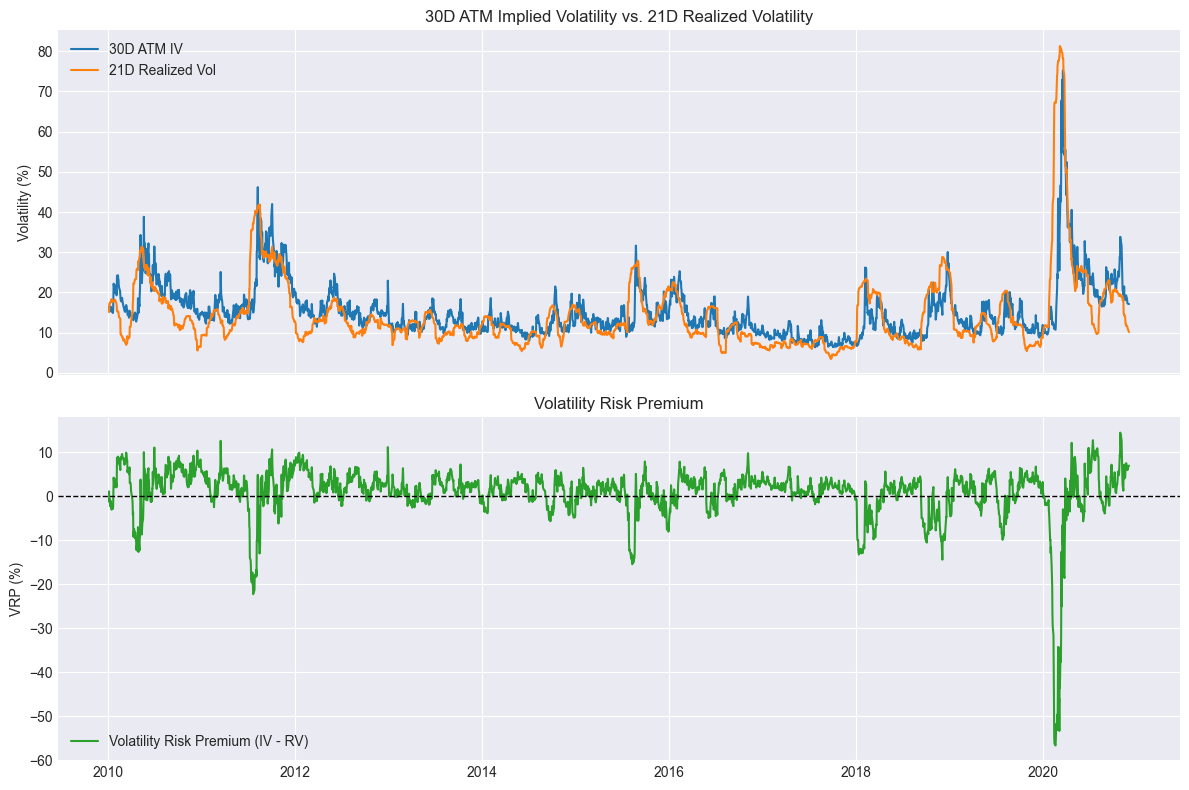

In [83]:
ph.plot_vrp(vol_df["iv_30d"], vol_df["rv_30d"], vol_df["vrp"])

During calm markets, the VRP is typically positive, whereas during crashes (e.g., the COVID-19 lockdown) realized volatility can exceed implied volatility when the market fails to anticipate the shock. It migth sugguest that a strategy consiting in selling preniums can be profitabel over the long run. 

## **Stylized facts 3: VRP has fat-tails and skewed distribution**

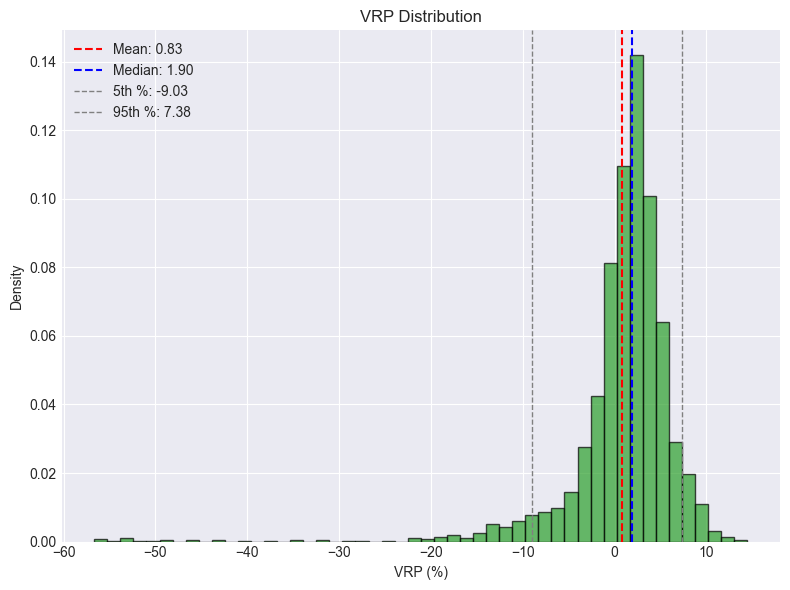

In [84]:
ph.plot_vrp_hist(vol_df["vrp"])

As you can see the VRP is positive in average but the presence how large left tails make its mean much less tha its median.
Thus excessive care msut be given to short vol strategies as they might be mostly mostly proftable but large blow ups can erode all prfoits accumulated over the years.
Thus the use of tail-risk filters like VIX Terme STructure, VVIX are essential to not avoid those large losess to materiazliee.

## **Stylised Fact 4 – VRP is Regime-Dependent**

The distribution of the Variance Risk Premium is **not stationary**.  
It shifts dramatically across volatility regimes:

- In **calm / low-volatility regimes**, VRP is usually positive and stable.  
- In **moderate / elevated volatility**, VRP often becomes larger (IV rises faster than RV).  
- In **stress / panic regimes**, VRP can remain **negative for extended periods**, and short-vol strategies become unprofitable.

This regime dependence is one of the key motivations for using **filters** and **regime-based sizing** in a VRP strategy.

In [85]:
bins = [-np.inf, 15, 20, 30, np.inf]

labels = [
    "15 <= VIX",
    "15 < VIX <= 20",
    "20 < VIX <= 30",
    "VIX >= 30",
]

vol_df["vix_bucket"] = pd.cut(vol_df["VIX"], bins=bins, labels=labels)

grouped = vol_df.groupby("vix_bucket", observed=True)["vrp"].agg(
    ["mean", "std", "max", "min", "skew", "count"]
)
grouped

,mean,std,max,min,skew,count
vix_bucket,,,,,,
15 <= VIX,0.399008,5.049666,6.5669,-56.6578,-6.224462,1179
15 < VIX <= 20,1.110012,5.793712,10.3696,-53.5814,-3.534401,864
20 < VIX <= 30,1.832298,6.666204,12.5993,-53.1338,-3.570301,518
VIX >= 30,-0.583986,11.778665,14.4542,-53.3508,-2.509325,187


On the full `2010–2020` sample, the typical size of the VRP and its variability both increase with VIX. 

- Extremely low-volatility regimes (VIX < 15) offer almost no premium.
- Intermediate regimes (20 < VIX ≤ 30) show the best risk–reward (high mean VRP relative to its dispersion). 
- Very high VIX(≥ 30) offers the richest VRP on average, but with much higher volatility and tail risk.

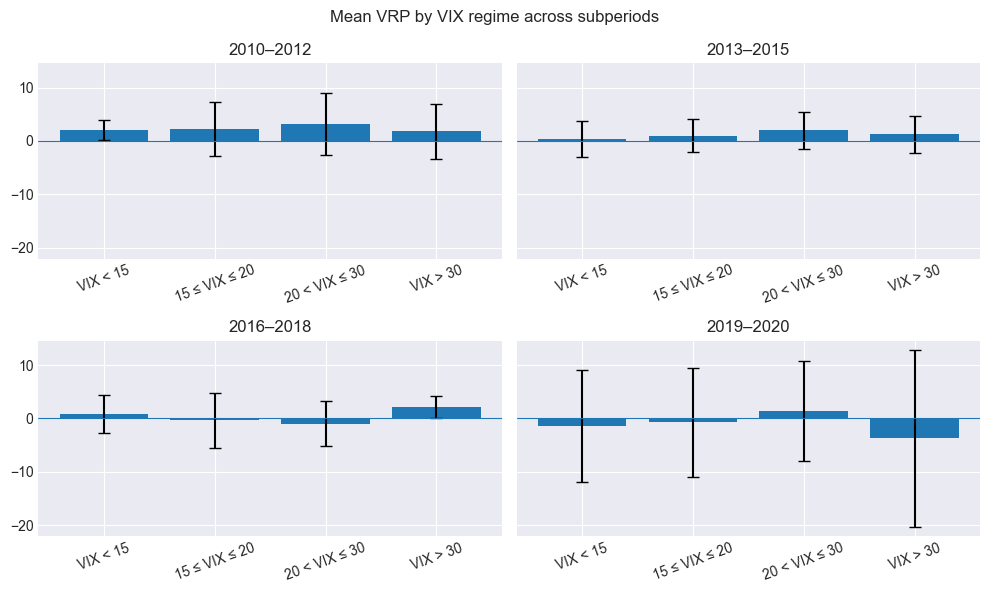

In [86]:
ph.plot_vrp_by_vix_bucket_subperiods(vol_df)

However, the subperiod breakdown shows that these bucket-level averages are
not stable over time:

- `2010–2015`: VRP is positive in most VIX regimes and increases with VIX.
- `2016–2018`: low-VIX buckets are close to flat; only VIX > 30 shows a strong
  positive premium.
- `2019–2020`: low-VIX regimes become outright negative, and even higher-VIX
  buckets show small means with very large dispersion.

In other words, the relation between VIX level and VRP has **shifted over
time**. The unconditional statistics hide this change. 

# **3. Implementation Choice – How We Harvest VRP**

There are several ways to sell volatility and capture the VRP:

- Short SPX options (straddles, strangles, butterflies, condors)
- Variance swaps
- VIX futures / short–vol ETPs

In this project we focus on **SPX options**, using simple 30-day structures that map cleanly to the
30D VRP we measure. We distinguish:

- **ATM Straddle (pure vol exposure)**  

  $$
  \Pi_{\text{straddle}}^{\text{long}} = C(K_0) + P(K_0)
  $$

  The **long** straddle is a classic long-volatility payoff: it profits from large moves of $S_T$
  away from the strike ($K_0 = S_0$). 
  When we **short** this structure (optionally delta-hedged in the
  backtest), we obtain clean exposure to realised variance, but with **unlimited downside**.

- **Iron Butterfly (straddle + OTM wings)**  

  $$
    \Pi_{\text{iron fly}}^{\text{long}}
    = C(K_0) + P(K_0) - \bigl(C(K_2) + P(K_1)\bigr),
  $$

  with strikes
  $$
  K_1 = S_0 - \Delta K,\quad
  K_0 = S_0,\quad
  K_2 = S_0 + \Delta K.
  $$

  To cap tail risk when shorting straddles or redecuign the prenium to be aid upfront when long straddles, we can add OTM “wings”. A convenient long iron butterfly
  payoff can be written as:

In the remainder of the notebook, “short straddle” and “short iron butterfly” will denote taking
the **short side** of these long payoffs, i.e. receiving the option premium and being short volatility.

In [87]:
# -------------------
# Configuration
# -------------------

S0 = 100.0         # spot
K0 = 100.0         # ATM strike
dK = 10.0          # wing distance for iron fly
K1 = K0 - dK       # lower wing
K2 = K0 + dK       # upper wing

T = 30 / 252       # 30 trading days to expiry
r = 0.02           # risk-free rate
q = 0.01           # dividend yield
sigma = 0.20       # implied vol (20%)

## **3.1 Payoff at maturity**

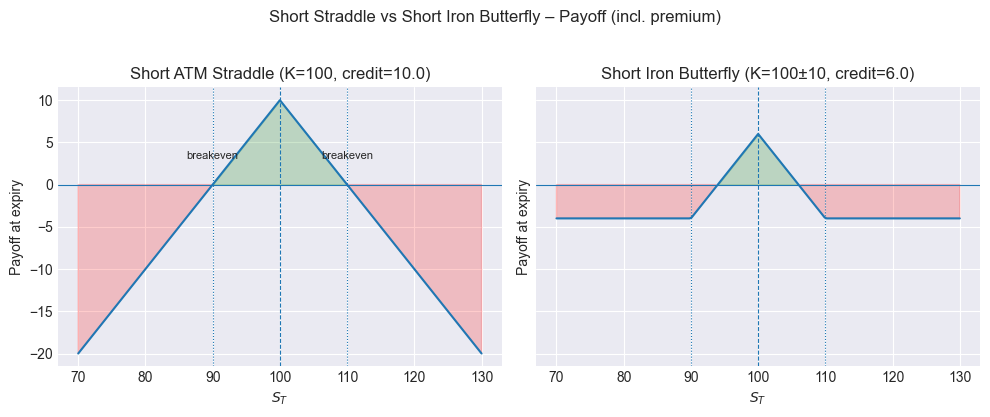

In [88]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

ph.plot_short_straddle_payoff(K=K0, net_premium=10.0, ax=axes[0])
ph.plot_short_iron_butterfly_payoff(K=K0, dK=dK, net_premium=6.0, ax=axes[1])

fig.suptitle("Short Straddle vs Short Iron Butterfly – Payoff (incl. premium)", y=1.03)
plt.tight_layout()
plt.show()

## **3.2 Greek profiles**

In [89]:
# ATM call/put at K0
gC0 = bs_greeks(S0, K0, T, sigma, r, q, option_type="call")
gP0 = bs_greeks(S0, K0, T, sigma, r, q, option_type="put")

# Wings for iron fly: call at K2, put at K1 (LONG in the long iron fly)
gC2 = bs_greeks(S0, K2, T, sigma, r, q, option_type="call")
gP1 = bs_greeks(S0, K1, T, sigma, r, q, option_type="put")

# -----------------------------
# 1) Short ATM straddle
# -----------------------------

delta_straddle = - (gC0["delta"] + gP0["delta"])
gamma_straddle = - (gC0["gamma"] + gP0["gamma"])
vega_straddle  = - (gC0["vega"]  + gP0["vega"])
theta_straddle = - (gC0["theta"] + gP0["theta"])

# -----------------------------
# 2) Short iron butterfly
# -----------------------------

delta_iron = - (gC0["delta"] + gP0["delta"] - gC2["delta"] - gP1["delta"])
gamma_iron = - (gC0["gamma"] + gP0["gamma"] - gC2["gamma"] - gP1["gamma"])
vega_iron  = - (gC0["vega"]  + gP0["vega"]  - gC2["vega"]  - gP1["vega"])
theta_iron = - (gC0["theta"] + gP0["theta"] - gC2["theta"] - gP1["theta"])

greeks = pd.DataFrame({
        "Delta": [delta_straddle, delta_iron],
        "Gamma": [gamma_straddle, gamma_iron],
        "Vega":  [vega_straddle,  vega_iron],
        "Theta": [theta_straddle, theta_iron],
    },
    index=["Short straddle", "Short iron fly"],
)

greeks

,Delta,Gamma,Vega,Theta
Short straddle,-0.041227,-0.115332,-27.460077,22.997775
Short iron fly,-0.006630,-0.074858,-17.823418,14.877576


A short straddle has higher (in absolute value) gamma, vega and theta exposure compared to a short iron fly.
This makes sense because the iron fly includes long wings (long OTM call and put) that add positive gamma and vega, and negative theta, which partially offset the Greeks of the short at-the-money options.

In addition you can see that there is some residual delta, whihc is usually hedged when it becomes significant (e.g $ |\Delta| > 0.1$)

## **3.3 P&L Distribution**

To build intuition about the risk/return trade-off, we compare the **P&L distributions**
of a short ATM straddle and a short iron butterfly in a simple toy model.

We assume the SPX follows a **Geometric Brownian Motion (GBM)** under a risk-neutral
measure and:

- price both structures at $t=0$ using Black–Scholes,
- simulate many terminal prices $S_T$,
- compute the **P&L of the short structures at expiry** (premium received minus payoff).

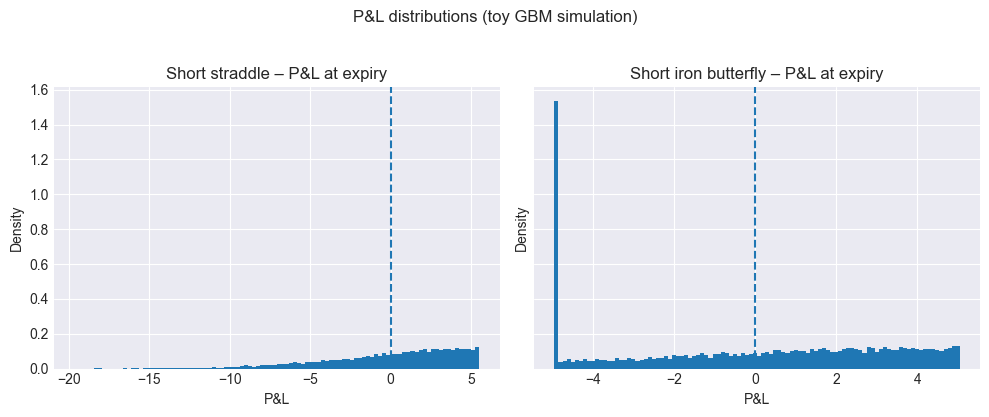

Short straddle: mean P&L = 0.019 , 5% quantile = -7.966
Short iron fly: mean P&L = 0.009 , 5% quantile = -4.952


In [ ]:
np.random.seed(1234)
dec = 3
n_paths = 10_000  # MC paths
r = q = 0.00     # no drift

# --- 1) Price structures at t=0 (net premium for shorts) ---

# Short straddle = short call(K0) + short put(K0)
price_call_K0 = bs_price(S0, K0, T, sigma, r, q, option_type="call")
price_put_K0  = bs_price(S0, K0, T, sigma, r, q, option_type="put")
premium_straddle_short = price_call_K0 + price_put_K0  # credit received

# Long iron fly payoff: +C(K0)+P(K0) - C(K2) - P(K1)
price_call_K2 = bs_price(S0, K2, T, sigma, r, q, option_type="call")
price_put_K1  = bs_price(S0, K1, T, sigma, r, q, option_type="put")
premium_iron_short = price_call_K0 + price_put_K0 - price_call_K2 - price_put_K1

# --- 2) Simulate terminal prices under GBM ---

z = np.random.randn(n_paths)
S_T = S0 * np.exp((r - q - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * z)

# --- 3) Compute payoff at expiry ---

# Straddle intrinsic payoff (long)
payoff_straddle_long = np.abs(S_T - K0)
# Short straddle P&L at expiry
pnl_straddle_short = premium_straddle_short - payoff_straddle_long

# Iron fly intrinsic payoff (long iron fly)
call_K0_payoff = np.maximum(S_T - K0, 0.0)
put_K0_payoff  = np.maximum(K0 - S_T, 0.0)
call_K2_payoff = np.maximum(S_T - K2, 0.0)
put_K1_payoff  = np.maximum(K1 - S_T, 0.0)

payoff_iron_long = call_K0_payoff + put_K0_payoff - call_K2_payoff - put_K1_payoff

# Short iron fly P&L at expiry
pnl_iron_short = premium_iron_short - payoff_iron_long

# --- 4) Plot P&L distributions ---
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

ph.plot_pnl_hist(pnl_straddle_short,
    ax=axes[0],
    title="Short straddle – P&L at expiry",
)
ph.plot_pnl_hist(
    pnl_iron_short,
    ax=axes[1],
    title="Short iron butterfly – P&L at expiry",
)

fig.suptitle("P&L distributions (toy GBM simulation)", y=1.03)
plt.tight_layout()
plt.show()

print("Short straddle: mean P&L =", round(np.mean(pnl_straddle_short), dec),
      ", 5% quantile =", round(np.quantile(pnl_straddle_short, 0.05), dec))
print("Short iron fly: mean P&L =", round(np.mean(pnl_iron_short), dec),
      ", 5% quantile =", round(np.quantile(pnl_iron_short, 0.05), dec))

The short straddle collects more premium than the short iron fly, but at the cost of much **larger tail losses**.
In more realistic dynamics with **stochastic volatility and jumps**, these large loss scenarios would occur **more frequently**, making the naked short straddle significantly more fragile than the hedged structure.

# **4. Baseline Strategy Prototype**

**Objective:** Build the simplest possible strategy that harvests VRP, with minimal parameters.

- Fix a simple trading rule:
  - Structure: e.g. short ATM index options / short variance swap proxy.
  - Tenor: e.g. target 30D maturity, rolled mechanically.
  - No dynamic sizing: 1 “unit” of short vol when conditions allow.
- Simulate P&L over time with:
  - Realistic transaction costs & bid–ask assumptions
  - Simple margin / leverage constraints
- Evaluate:
  - Annualised return, vol, Sharpe / Sortino
  - Max drawdown and recovery time
  - Behaviour across subperiods and regimes (pre/post-crisis, low/high IV).

This becomes the **baseline** that all later variants are compared against.


In [167]:
options_chain_long = options_chain_wide_to_long(options_chain).collect()
options_chain_long = options_chain_long.to_pandas().set_index("trade_date")
options_chain_long

,ticker,expiry_date,dte,yte,underlying_price,spot_price,strike,smoothed_iv,risk_free_rate,dividend_yield,...,mid_iv,mid_price,model_price,open_interest,rel_spread,rho,theta,vega,volume,option_type
trade_date,,,,,,,,,,,,,,,,,,,,,
2010-01-04,SPY,2010-01-16,12,0.03288,113.33,113.33,80.0,0.219567,0.0005,0.0,...,0.45196,33.325,33.33,55,0.004501,0.000000,0.000000,0.000000,0,C
2010-01-04,SPY,2010-01-16,12,0.03288,113.33,113.33,80.0,0.219567,0.0005,0.0,...,0.37337,0.010,0.00,9666,2.000000,0.000000,0.000000,0.000000,0,P
2010-01-04,SPY,2010-01-16,12,0.03288,113.33,113.33,81.0,0.219567,0.0005,0.0,...,0.43786,32.325,32.33,1,0.004640,0.000000,0.000000,0.000000,1,C
2010-01-04,SPY,2010-01-16,12,0.03288,113.33,113.33,81.0,0.219567,0.0005,0.0,...,0.36115,0.010,0.00,3006,2.000000,0.000000,0.000000,0.000000,0,P
2010-01-04,SPY,2010-01-16,12,0.03288,113.33,113.33,82.0,0.219567,0.0005,0.0,...,0.42394,31.300,31.33,8,0.006390,0.000000,0.000000,0.000000,0,C
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-31,SPY,2021-02-19,50,0.13699,373.32,373.32,475.0,0.156345,0.0009,0.0,...,0.15924,101.660,101.68,1,0.004918,0.000007,-0.000013,0.000107,0,P
2020-12-31,SPY,2021-02-19,50,0.13699,373.32,373.32,480.0,0.156345,0.0009,0.0,...,0.22862,0.015,0.02,91,0.666667,0.000003,-0.000006,0.000049,0,C
2020-12-31,SPY,2021-02-19,50,0.13699,373.32,373.32,480.0,0.156345,0.0009,0.0,...,0.16648,106.670,106.68,0,0.004875,0.000003,-0.000006,0.000049,0,P


In [174]:
from volatility_trading.backtesting import BacktestConfig, to_daily_mtm
from volatility_trading.backtesting.engine import Backtester
from volatility_trading.backtesting.plotting import (
    plot_full_performance,
    print_perf_metrics,
)
from volatility_trading.signals import ShortOnlySignal
from volatility_trading.strategies import VRPHarvestingStrategy

sig = ShortOnlySignal()
strat = VRPHarvestingStrategy(signal=sig, holding_period=10)
cfg = BacktestConfig(initial_capital=20000, commission_per_leg=0.0)

options_red = options_chain_long.loc["2014":"2016"]
data = {
    "options": options_red,
    "features": None,
    "hedge": None
}

In [175]:
bt = Backtester(data=data, strategy=strat, config=cfg)
trades, mtm = bt.run()
daily_mtm = to_daily_mtm(mtm, cfg.initial_capital)

🔍 Overall Performance Metrics
Sharpe Ratio           : 0.37
CAGR                   : 2.19%
Average Drawdown       : -2.13%
Max Drawdown           : -7.72%
Max Drawdown Duration  : 316 days
Historical VaR (99%)   : -0.96%
Historical CVaR (99%)  : -1.58%
Total P&L              : $1,338.00
Profit Factor          : 1.25
Trade Frequency (ann.) : 34.8 trades/year
Total Trades           : 104
Win Rate               : 71.15%
Average Win P&L        : $91.74
Average Loss P&L       : $-181.50

📊 Performance by Contract Size
           win_rate  num_trades  total_win_pnl  total_loss_pnl  total_pnl
contracts                                                                
1              0.71         104         6789.0         -5445.0     1344.0



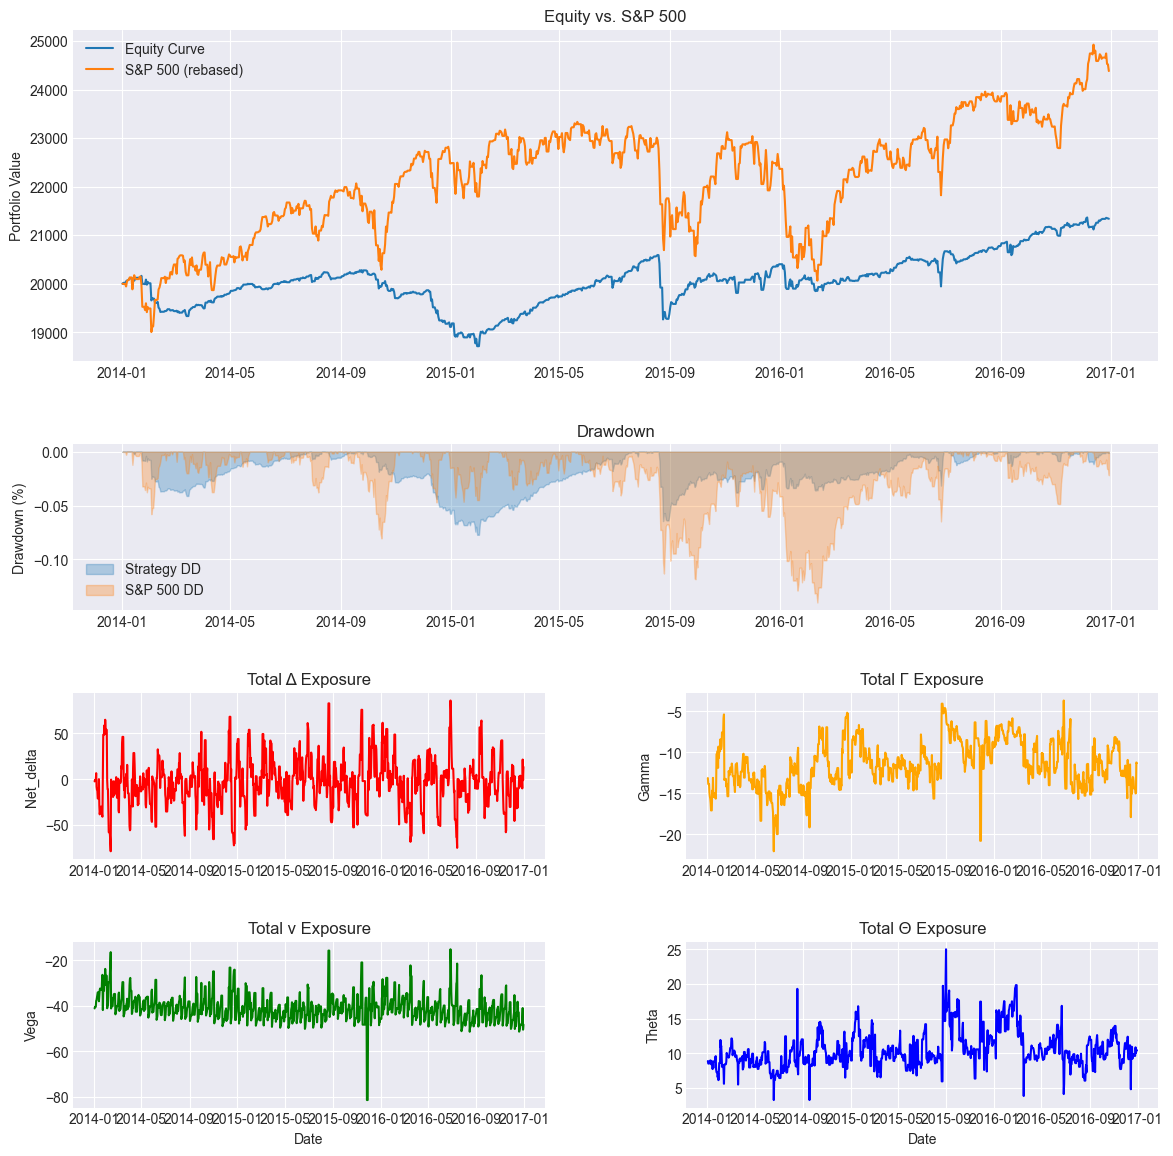

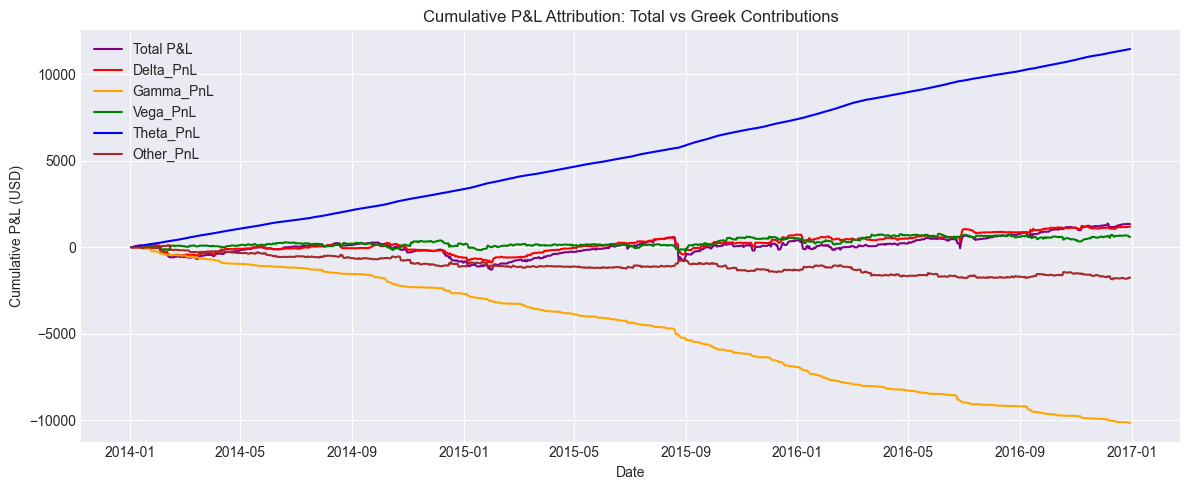

In [176]:
from volatility_trading.backtesting.plotting import plot_pnl_attribution

sp500 = options_chain_long["spot_price"].groupby("trade_date").first()
print_perf_metrics(trades, daily_mtm)
plot_full_performance(sp500, daily_mtm)
plot_pnl_attribution(daily_mtm)